In [1]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = "svg"

In [2]:
from time import sleep
from typing import Optional
from urllib.parse import quote

import requests


def inspire_query_hits(query: str, subject: Optional[str] = None) -> int:
    URL = f"https://inspirehep.net/api/literature?size=1&q={quote(query)}"
    if subject is not None:
        URL += f"&subject={quote(subject)}"
    res = requests.get(URL)
    if res.status_code == 429:
        wait_ms = float(res.headers["X-Retry-In"].replace("ms", ""))
        sleep(wait_ms * 1e-3)
        return inspire_query_hits(query, subject)
    res.raise_for_status()
    d = res.json()
    try:
        return d["hits"]["total"]
    except KeyError:
        return 0

In [3]:
%%time

YEARS = range(2005, 2021)

DISCIPLINES = [
    "Experiment-HEP",
    "Phenomenology-HEP",
    "Astrophysics",
]

LANGS = [
    "Python",
#    "C++",
    "Fortran",
    "Mathematica",
    "IDL",
]

data = {
    disc: pd.DataFrame({
        lang: {
            year: inspire_query_hits(query=f"{lang} and date={year}", subject=disc)
            for year in YEARS
        }
        for lang in LANGS
    })
    for disc in DISCIPLINES
}

CPU times: user 7.52 s, sys: 267 ms, total: 7.79 s
Wall time: 1min 32s


In [4]:
data

{'Experiment-HEP':       Python  Fortran  Mathematica  IDL
 2005       0        0            0    0
 2006       0        0            0    0
 2007       0        0            0    0
 2008       0        0            0    0
 2009       1        0            0    0
 2010       2        5            0    0
 2011       0        4            2    0
 2012       1        3            0    0
 2013       5        5            4    0
 2014      68        2            6    0
 2015     129        3            2    0
 2016     160        5            5    0
 2017     196        1            5    0
 2018     217        2            4    0
 2019     186        5            4    0
 2020     103        2            3    0,
 'Phenomenology-HEP':       Python  Fortran  Mathematica  IDL
 2005       0       13            7    0
 2006       0       23            8    0
 2007       0       19            8    0
 2008       0       15           13    0
 2009       1       17           15    0
 2010       1    

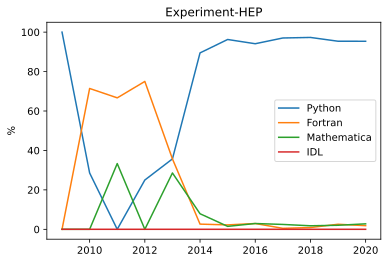

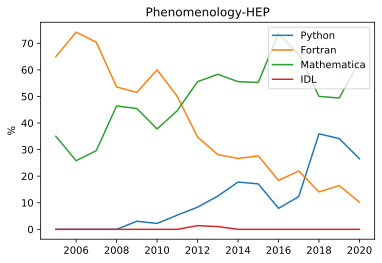

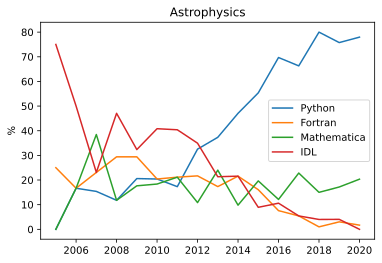

In [5]:
for disc in DISCIPLINES:
    df_fixed = data[disc].copy()
    # double 2020 count to account for second half
    df_fixed.loc[2020] = df_fixed.loc[2020] * 2
    # convert to percentage
    df_fixed = 100 * df_fixed.div(df_fixed.sum(axis=1), axis=0)
    
    plt.title(disc)
    df_fixed.plot(ax=plt.gca())
    plt.ylabel("%")
    plt.savefig(f"Lang_{disc}.svg", bbox_inches="tight")
    plt.show()